In [ ]:
%pip install yolov5
%pip install deskew
%pip install easyocr

In [2]:
from PIL import Image
import yolov5
from deskew import determine_skew
import easyocr
import numpy as np


In [ ]:


model = yolov5.load('keremberke/yolov5n-license-plate')

# set model parameters
model.conf = 0.25  # NMS confidence threshold
model.iou = 0.45  # NMS IoU threshold
model.agnostic = False  # NMS class-agnostic
model.multi_label = False  # NMS multiple labels per box
model.max_det = 1000  # maximum number of detections per image

def find_plate_image(image):
    """Use a yolov5 model to find the license plate in an image."""
    results = model(image)
    predictions = results.pred[0]
    boxes = [ (int(x1), int(y1), int(x2), int(y2)) for (x1, y1, x2, y2) in predictions[:, :4]]
    if boxes:
        plate = image.crop(boxes[0])
        return plate
    return None


In [11]:
def enhance_plate_image(plate: Image, deskew:bool=False) -> Image:
    """
        Enhance the plate image to improve OCR accuracy.
    """

    # keep only the blue channel
    _, _, plate = plate.convert('RGB').split()
    
    # determine the angle before deskewing
    angle = determine_skew(np.array(plate), min_angle=-10, max_angle=10) if deskew else 0

    # Resize the image to a fixed width while keeping the aspect ratio
    plate = plate.resize((1024, int(1024 * plate.height / plate.width)))
    
    if angle != 0:
        plate = plate.rotate(-angle, expand=True)

    # determine the darkest and lightest pixel values
    min_val, max_val = plate.getextrema()

    # maximize contrast
    plate = plate.point(lambda x: 255 * (x - min_val) / (max_val - min_val))
    
    return plate


In [13]:

def extract_plate_text(image: Image, deskew:bool=False) -> str:
    """
        Extract the text from the license plate in the image.
    """ 
    plate = enhance_plate_image(find_plate_image(image), deskew=deskew)
    reader = easyocr.Reader(lang_list=['fr'])
    result = reader.readtext(np.array(plate))
    if result:
        txt = ''.join(item[1] for item in result)
        txt = ''.join([c for c in txt if c.isalnum()])
        return txt.upper()
    return None

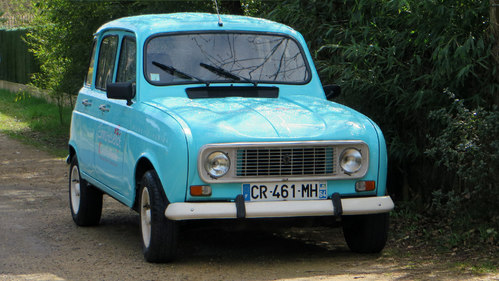

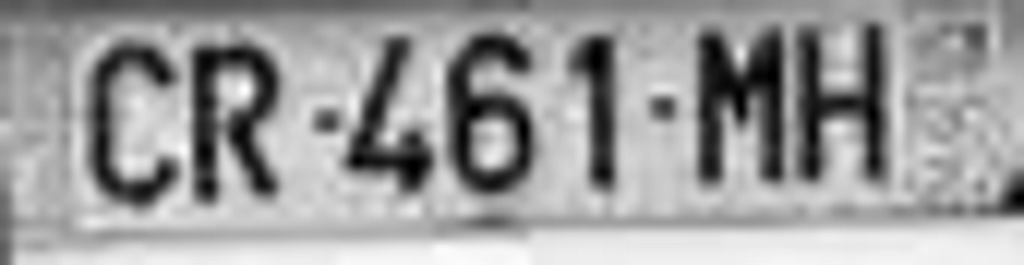

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


'CR461MH'

In [14]:
def test_extract_plate_text(image: Image):
    plate = find_plate_image(image)
    enhanced_plate = enhance_plate_image(plate)
    display(image)
    display(plate)
    display(enhanced_plate)
    print(extract_plate_text(image))

image = Image.open('./samples/voiture-bleue-plaque-immatriculation-main-12878161.jpg')
display(image)
display(enhance_plate_image(find_plate_image(image)))
extract_plate_text(image)
